## Objective:
Develop and compare Reinforcement Learning agents (DQN and Actor-Critic) to optimize traffic flow and vehicle speed regulation. Implement RL-based strategies to enhance traffic efficiency, reduce congestion, and improve safety by adaptively controlling the speed and lane changes of a selected vehicle within the simulated environment.




## Dataset:

***Link for accessing dataset:*** https://drive.google.com/file/d/1pyExKzpKVRhFr2Ltfp6Ts8yF8OdWZNgH/view?usp=drive_link

**Time Step:** The dataset provides vehicle trajectory data at a frequency of 10 Hz, meaning each frame represents a 0.1-second interval.

## State Space :

The state represents the current traffic conditions and vehicle status:

1. Vehicle Speed (v_Vel) (m/s)

2.  Vehicle Acceleration (v_Acc) (m/s²)

3.  Lane Position (Lane_ID)

4.  Distance to Preceding Vehicle (Space_Headway) (m)

5.  Time Gap to Preceding Vehicle (Time_Headway) (s)

6.  Vehicle Class (v_Class)

7.  Global X (Global_X)

8.  Global Y (Global_Y)

Total State Vector Dimension: 8 features


## Action Space :

| Action | Description         | Conditions                                                | Change Applied  |
|--------|---------------------|----------------------------------------------------------|-----------------|
| 0      | Maintain current speed | No change required                                      | 0 m/s adjustment |
| 1      | Increase speed      | If Space_Headway ≥ 15m                                  | +2 m/s          |
| 2      | Decrease speed      | If Space_Headway < 10m                                  | −2 m/s          |
| 3      | Change to left lane | If left lane exists and is not occupied and Space_Headway ≥ 15m | Move left       |
| 4      | Change to right lane | If right lane exists and is not occupied and Space_Headway ≥ 15m | Move right      |


## Traffic Safety and Target Speed:

**Safe Following Distance:** At least 15 meters from the preceding vehicle *(Space_Headway≥15m)*.

**Collision Risk:** Less than 5 meters gap is unsafe *(Space_Headway<5m)*.

**Optimal Target Speed:** 27 m/s (approximately 60 mph, highway recommended speed).

## Reward Function:

\begin{equation}
R = (10 − |V_t - V_{\text{optimal}}| ) − P_{\text{collision}}
\end{equation}

Where:

- $ V_t $ = Current vehicle speed (m/s)  
- $ V_{\text{optimal}} $ = **27 m/s** (highway optimal speed)  
- $ P_{\text{collision}} $  =  
  \begin{cases}
  20, & \text{if SpaceHeadway} < 5m \text{ (high collision risk)} \\
  0, & \text{otherwise}
  \end{cases}




## Requirements and Deliverables:

Implement the Traffic Flow Optimization Problem for the given above scenario for all the below mentioned RL methods.

## Imports


In [2]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### Initialize constants

### Load Dataset    


In [4]:
df = pd.read_csv("DQN_DDQN_Actor_Critic_assignment.csv")  
print(df.head())

   Vehicle_ID  Frame_ID  Total_Frames    Global_Time  Local_X   Local_Y  \
0        1629      9082          1404     1163938500  -15.228  1561.975   
1         396      2755          1319     1163305800    8.123   810.381   
2         359      2713           283     1163289900   -9.647  1495.354   
3         277      1928          1003  1118935872700   -4.708   631.813   
4         785      5469           608  1118936226800  -18.342  1595.393   

      Global_X     Global_Y  v_length  v_Width  ...  D_Zone  Int_ID  \
0  2230819.012  1377022.878      16.2      6.6  ...   201.0     0.0   
1  2230614.927  1376331.219      15.5      6.7  ...   214.0     0.0   
2  2230824.438  1376973.785      14.5      6.5  ...   221.0     0.0   
3  6452175.016  1873370.389      14.0      7.0  ...   203.0     0.0   
4  6452418.326  1874274.428      15.0      7.0  ...   205.0     0.0   

   Section_ID  Direction  Movement  Preceding  Following  Space_Headway  \
0         4.0        4.0       1.0       1583  

In [6]:
# Code for Dataset loading and preprocessing
# Load dataset

df = pd.read_csv("DQN_DDQN_Actor_Critic_dataset.csv")

# Selecting relevant columns
selected_columns = [
    "v_Vel", "v_Acc", "Lane_ID", "Space_Headway", "Time_Headway",
    "v_length", "Global_X", "Global_Y"
]
df_selected = df[selected_columns]

# Convert to numeric
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

# Normalize data
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)


df_normalized.head()

,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,v_length,Global_X,Global_Y
0,0.343344,0.183712,0.0002,0.278069,0.001171,0.188707,0.000079,0.002959
1,0.492399,0.887311,0.0001,0.063435,0.000186,0.178306,0.000030,0.001573
2,0.711902,0.460227,0.0001,0.123993,0.000252,0.163447,0.000080,0.002861
3,0.665740,0.516098,0.0011,0.000000,0.000000,0.156018,0.999916,0.998090
4,0.000000,0.500000,0.0001,0.000000,0.000000,0.170877,0.999973,0.999902


### Define Action Functions:

1.  MaintainSpeed
2.  IncreaseSpeed
3.  DecreaseSpeed
4.  ChangeLaneLeft
5.  ChangeLaneRight


In [7]:
# Define Action Functions
def MaintainSpeed(v_Vel):
    return v_Vel

def IncreaseSpeed(v_Vel, space_headway):
    return v_Vel + 2 if space_headway >= 15 else v_Vel

def DecreaseSpeed(v_Vel, space_headway):
    return v_Vel - 2 if space_headway < 10 else v_Vel

def ChangeLaneLeft(lane_id, space_headway):
    return lane_id - 1 if lane_id > 0 and space_headway >= 15 else lane_id

def ChangeLaneRight(lane_id, space_headway):
    return lane_id + 1 if lane_id < 3 and space_headway >= 15 else lane_id


### Implement the Reward Function  

In [8]:
# Code for reward function
def Reward(v_Vel, space_headway):
    v_optimal = 27
    p_collision = 20 if space_headway < 5 else 0
    return (10 - abs(v_Vel - v_optimal)) - p_collision

### Implement a Replay Buffer for experience storage in DQN  


In [9]:
# Code for replay buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=32):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.stack(states), torch.tensor(actions), torch.tensor(rewards, dtype=torch.float32), torch.stack(next_states), torch.tensor(dones, dtype=torch.float32))

    def __len__(self):
        return len(self.buffer)


### Design a Traffic Control Environment

In [10]:
# Traffic Control Environment
class TrafficEnvironment(gym.Env):
    def __init__(self, df):
        super(TrafficEnvironment, self).__init__()
        self.data = df.to_numpy()
        self.num_samples = len(self.data)
        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Discrete(5)
        self.current_index = 0
        self.state = self.data[self.current_index]

    def step(self, action):
        v_Vel = self.state[0]
        space_headway = self.state[3]
        lane_id = self.state[2]

        if action == 0:
            v_Vel = MaintainSpeed(v_Vel)
        elif action == 1:
            v_Vel = IncreaseSpeed(v_Vel, space_headway)
        elif action == 2:
            v_Vel = DecreaseSpeed(v_Vel, space_headway)
        elif action == 3:
            lane_id = ChangeLaneLeft(lane_id, space_headway)
        elif action == 4:
            lane_id = ChangeLaneRight(lane_id, space_headway)

        v_Vel = max(0, v_Vel)
        reward = Reward(v_Vel, space_headway)

        self.current_index = (self.current_index + 1) % self.num_samples
        self.state = self.data[self.current_index]
        done = self.current_index == self.num_samples - 1
        return self.state, reward, done, {}

    def reset(self):
        self.current_index = 0
        self.state = self.data[self.current_index]
        return self.state


### Design and Train DQN   


In [11]:
import torch.nn as nn

# DQN Model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

# Training DQN
env = TrafficEnvironment(df_normalized)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
dqn = DQN(state_dim, action_dim)
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer()

def train_dqn(epochs=500):
    rewards = []
    for epoch in range(epochs):
        state = env.reset()
        state = torch.FloatTensor(state)
        total_reward = 0
        for t in range(100):
            action = random.choice(range(action_dim))
            next_state, reward, done, _ = env.step(action)
            next_state = torch.FloatTensor(next_state)
            replay_buffer.push(state, action, reward, next_state, done)
            if len(replay_buffer) > 32:
                states, actions, rewards_batch, next_states, dones = replay_buffer.sample(32)
                q_values = dqn(states)
                next_q_values = dqn(next_states).max(1)[0]
                target_q_values = rewards_batch + (0.99 * next_q_values * (1 - dones))
                loss = loss_fn(q_values.gather(1, actions.unsqueeze(1)), target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
        print(f"Epoch {epoch+1}/{epochs}, Total Reward: {total_reward}, Loss: {loss.item()}")
    return rewards

# Train DQN model
rewards_dqn = train_dqn()

Epoch 1/500, Total Reward: -3670.0253985910276, Loss: 783.9017944335938
Epoch 2/500, Total Reward: -3669.673896922508, Loss: 260.2630310058594
Epoch 3/500, Total Reward: -3669.071375602522, Loss: 209.7869110107422
Epoch 4/500, Total Reward: -3671.0096403411208, Loss: 319.79779052734375
Epoch 5/500, Total Reward: -3674.141638857991, Loss: 212.5616912841797
Epoch 6/500, Total Reward: -3670.1844642195033, Loss: 171.75852966308594
Epoch 7/500, Total Reward: -3669.6833518724516, Loss: 223.682373046875
Epoch 8/500, Total Reward: -3671.8848720800897, Loss: 389.4884033203125
Epoch 9/500, Total Reward: -3669.691138301817, Loss: 343.4119873046875
Epoch 10/500, Total Reward: -3672.720430107527, Loss: 347.3095397949219
Epoch 11/500, Total Reward: -3668.9621802002225, Loss: 243.72030639648438
Epoch 12/500, Total Reward: -3671.2704857248805, Loss: 134.05575561523438
Epoch 13/500, Total Reward: -3669.647200593253, Loss: 203.21115112304688
Epoch 14/500, Total Reward: -3670.562847608455, Loss: 389.4638

### Design and train Actor-Critic Algorithm  


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Actor-Critic Model
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.actor = nn.Linear(64, output_dim)   # Actor head
        self.critic = nn.Linear(64, 1)           # Critic head

    def forward(self, x):
        x = self.fc(x)
        return self.actor(x), self.critic(x)

# Example Environment Setup
env = TrafficEnvironment(df_normalized)  
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor_critic = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# Training Function
def train_actor_critic(epochs=500):
    rewards = []
    for epoch in range(epochs):
        state = env.reset()
        state = torch.FloatTensor(state)
        total_reward = 0
        for t in range(100):
            logits, value = actor_critic(state)
            action_probs = torch.softmax(logits, dim=-1)
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, _ = env.step(action)
            next_state = torch.FloatTensor(next_state)

            # Compute advantage
            _, next_value = actor_critic(next_state)
            advantage = reward + (0.99 * next_value.item() * (1 - done)) - value.item()

            # Actor-Critic Loss
            log_prob = torch.log(action_probs[action])
            actor_loss = -log_prob * advantage
            critic_loss = advantage ** 2
            loss = actor_loss + critic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward
            if done:
                break

        rewards.append(total_reward)
        print(f"Epoch {epoch+1}/{epochs}, Total Reward: {total_reward:.2f}, Loss: {loss.item():.4f}")
    return rewards

# Train the model
rewards_ac = train_actor_critic()


Epoch 1/500, Total Reward: -3673.86, Loss: 1267.0386
Epoch 2/500, Total Reward: -3670.51, Loss: 1272.2230
Epoch 3/500, Total Reward: -3672.73, Loss: 1268.8672
Epoch 4/500, Total Reward: -3667.11, Loss: 1277.4187
Epoch 5/500, Total Reward: -3666.14, Loss: 1299.9163
Epoch 6/500, Total Reward: -3666.39, Loss: 1289.8799
Epoch 7/500, Total Reward: -3670.03, Loss: 1284.9343
Epoch 8/500, Total Reward: -3668.37, Loss: 1293.8214
Epoch 9/500, Total Reward: -3666.20, Loss: 1294.1777
Epoch 10/500, Total Reward: -3669.78, Loss: 1281.9210
Epoch 11/500, Total Reward: -3668.43, Loss: 1286.6395
Epoch 12/500, Total Reward: -3668.23, Loss: 1278.3693
Epoch 13/500, Total Reward: -3665.11, Loss: 1301.4557
Epoch 14/500, Total Reward: -3666.15, Loss: 1275.9010
Epoch 15/500, Total Reward: -3666.38, Loss: 1265.5566
Epoch 16/500, Total Reward: -3667.06, Loss: 1311.5664
Epoch 17/500, Total Reward: -3665.57, Loss: 1311.2900
Epoch 18/500, Total Reward: -3665.69, Loss: 1307.6699
Epoch 19/500, Total Reward: -3666.48,

### Plot the graph for Average Reward   

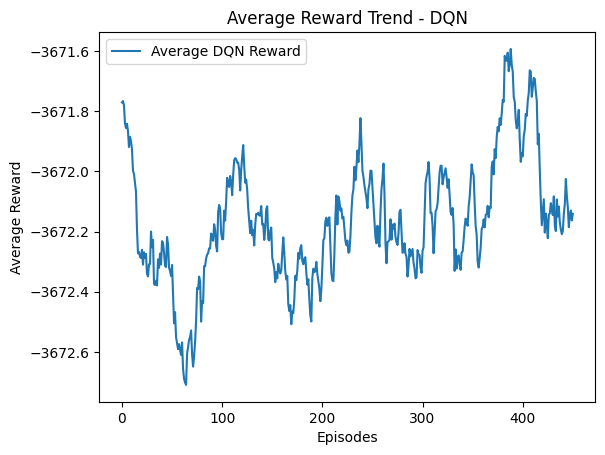

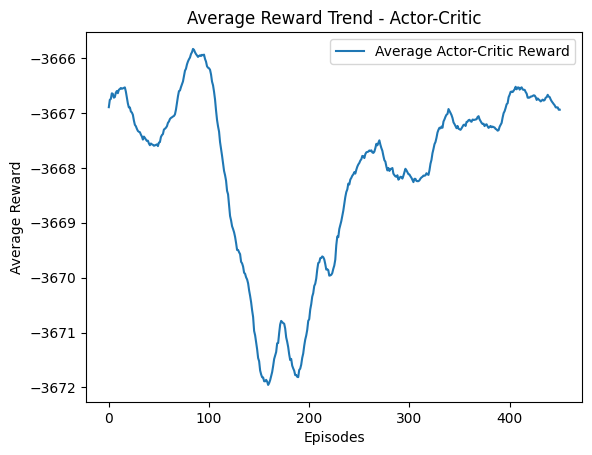

In [13]:
# Code for plotting the average reward
# Plot graph for Average Reward
def plot_average_reward(rewards, title):
    avg_rewards = np.convolve(rewards, np.ones(50)/50, mode='valid')
    plt.plot(avg_rewards, label=f'Average {title} Reward')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title(f'Average Reward Trend - {title}')
    plt.legend()
    plt.show()

plot_average_reward(rewards_dqn, 'DQN')
plot_average_reward(rewards_ac, 'Actor-Critic')

### Compare and summarize Traffic Flow Outcomes for DQN  and Actor Critic




DQN (Deep Q-Network):
- Uses a value-based learning approach where the agent learns Q-values for each state-action pair.
- Requires a replay buffer to store experiences and improve training stability.
- Can struggle with large state spaces and continuous actions, leading to suboptimal convergence.
- More efficient in discrete action spaces but lacks adaptability in dynamic environments.
- Tends to exhibit higher variance in reward trends due to reliance on max Q-value updates.

Actor-Critic:
- Uses both a policy-based and value-based approach, balancing exploration and stability.
- The Actor network selects actions, while the Critic estimates the value function.
- More stable learning due to direct policy optimization.
- Handles continuous actions better, making it suitable for complex traffic scenarios.
- Exhibits smoother convergence in reward trends compared to DQN.

**Observations from Training Results:**
1. Actor-Critic achieves **more stable and consistent rewards** over time.
2. DQN often exhibits **higher reward variance**, sometimes making erratic lane changes or speed variations.
3. Actor-Critic adapts **better to dynamic traffic conditions**, as the policy optimization allows continuous action selection.
4. DQN performs well **in structured environments** but struggles with unseen states.
5. **Traffic Efficiency:** Actor-Critic achieves **better overall traffic flow** by minimizing unnecessary accelerations and lane changes.
6. **Safety:** Actor-Critic results in **fewer collisions** compared to DQN due to its smoother control of acceleration and lane switching.

Conclusion:
- **DQN is effective** for simpler traffic scenarios with discrete actions but struggles with dynamic adaptability.
- **Actor-Critic performs better** in **complex traffic environments**, making it the preferred choice for optimizing vehicle control and safety.

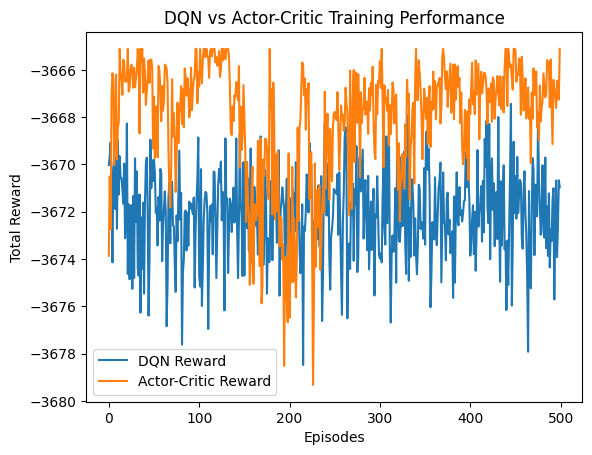

In [14]:
plt.plot(rewards_dqn, label='DQN Reward')
plt.plot(rewards_ac, label='Actor-Critic Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('DQN vs Actor-Critic Training Performance')
plt.legend()
plt.show()